# <hr><b>Simulation of a Transit Method for Detection of Exoplanet<b><hr>
# Our aim is to see which approach is better for teaching  the '**Transit method**' for Undergrad and advanced high school students and also to give them hands-on experience.    
#### We simulate the star-planet system in VPYTHON and record its video. Tracker software works as a satellite which analyses the video and generate the data in terms of time and flux. We then use the csv file of this data and run python algorithms on it to look for exoplanet and derive its parameters. We also analyse the same data using Tracker built-in tools and get the parameters. We then compare the obtained results by both the approaches to the VPYTHON code's input parameters for our system and state the conclusion
    


### First we import the required packages and read the data file using pandas.

In [32]:
#Importing the required packages and reading the data file
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy import units as u


#Separating the coloumns of the file in different variables
transit = pd.read_csv("transit_1.csv", sep=',')
transit=transit['t,B'].str.split(',',expand=True)
transit.columns=['t','B']
transit=transit.astype(dtype=float,copy=False,errors='ignore')
t = transit["t"] #array for time in days*u.day
y = transit["B"] #array for flux



#### We can see the data type of each column to begin our analysis

In [33]:

transit.info()
transit


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t       281 non-null    float64
 1   B       281 non-null    float64
dtypes: float64(2)
memory usage: 4.5 KB


,t,B
0,0.00,192.822758
1,0.08,192.822758
2,0.12,192.822758
3,0.20,192.822758
4,0.28,192.823430
...,...,...
276,18.44,192.854717
277,18.52,192.854749
278,18.60,192.854566
279,18.64,192.854498


### Since our system is ideal in VPython, we add noise to our flux array.

In [34]:
rand = np.random.RandomState(42)
y2 = np.ones_like(t)
y2[np.abs((t*1.9 + 12.5)%8.0-1)<0.08] = 1.0 - 0.4
y2 += 0.01 * rand.randn(len(t))
s = np.sin(2*np.pi*t)+0.1+rand.randn(len(t))
y=y+s+y2
y=y/y.max() # Normalizing the flux array

###  We have added the noise, then we can see the plot of the lightcurve

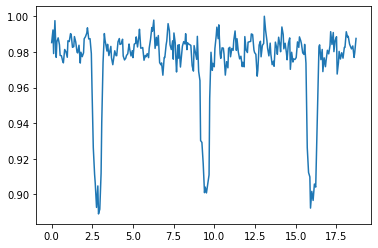

In [35]:
plt.plot(t,y)

### What we saw was star's wobbling and the hidden transit if the planet. Since, we are intrested in planet, we must remove the wobbling of the star as best as possible using the filter.
### Here we use the medfilt from scipy package to fit the star's wobble and remove it.

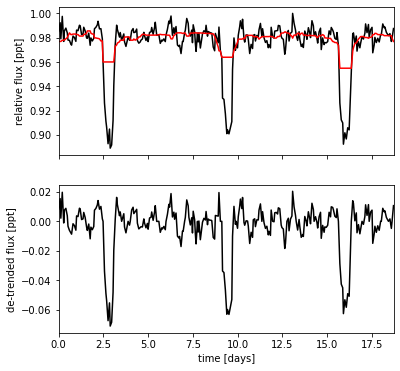

In [36]:
from scipy.signal import medfilt
trend = medfilt(y,19) # Applying medfilt
mu = np.median(y)
y_filt =(y - trend)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend,'r')
ax.set_ylabel("relative flux [ppt]")

ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

### Now that we applied our filter, we can start looking for exoplanet's features. i.e we will plot the periodogram using BoxLeastSquare of the Astropy

In [37]:
from astropy.timeseries import BoxLeastSquares
durations = np.linspace(0.1,1,100)
model=BoxLeastSquares(t,y_filt)
pg=model.autopower(durations)


## Let's find the best period at max power and print it. 

6.584811496602733


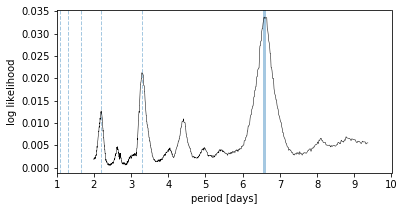

In [38]:
# Find the period of the peak
period = pg.period[np.argmax(pg.power)]
print(period)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the periodogram
ax.plot(pg.period, pg.power, "k", lw=0.5)

ax.set_xlim(1,10)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

## Let's view the region of the best period.

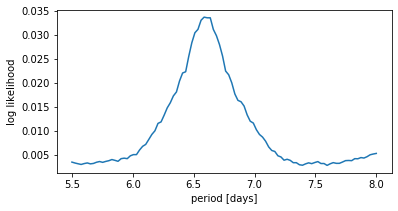

In [39]:
true_period=np.linspace(5.5,8,100)
pg2=model.power(true_period,durations)
fig, ax2 = plt.subplots(1, 1, figsize=(6, 3))
ax2.plot(pg2.period,pg2.power)
ax2.set_xlim()
ax2.set_xlabel("period [days]")
ax2.set_ylabel("log likelihood");

#### Compute other observables using astropy.compute_stats method at the max power and print them for further calculations.

In [40]:
max_power=np.argmax(pg.power)
stats=model.compute_stats(pg.period[max_power],pg.duration[max_power],pg.transit_time[max_power])
depth=stats['depth']
transit_timings=stats['transit_times']
period2=period*u.day
print(f'Observed Depth is :{depth}')
print(f'Transit Timings are: {transit_timings}')
print(f'Transit Duration is apprx:{pg.duration[max_power]}')
print(f'Orbital Period is:{period2}')

Observed Depth is :(0.05088562526034002, 0.20587157911909415)
Transit Timings are: [ 2.835       9.4198115  16.00462299]
Transit Duration is apprx:0.5700000000000001
Orbital Period is:6.584811496602733 d


#### It's always useful to fit your data by modeling it to verify your results.

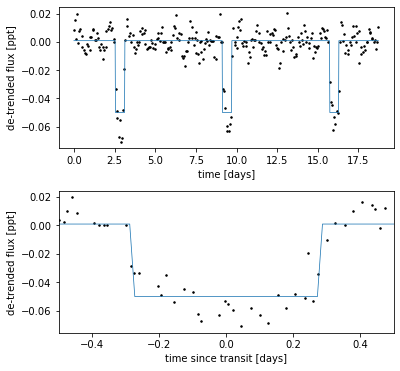

In [41]:
# Extract the parameters of the best-fit model
max_power = np.argmax(pg.power)
mod_period = pg.period[max_power]
mod_t0 = pg.transit_time[max_power]
mod_duration = pg.duration[max_power]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(t, y_filt, ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model.model(x, mod_period, mod_duration, mod_t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim()
ax.set_ylim()
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
x = (t - mod_t0 + 0.5*mod_period) % mod_period - 0.5*mod_period
m = np.abs(x) < 0.5 * u.day
ax.plot(x[m], y_filt[m], ".k", ms=3)

# Over-plot the best fit model
x = np.linspace(-0.5, 1, 100) 
f = model.model(x + mod_t0, mod_period, mod_duration, mod_t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]");

#### Since our data is inlined with our model, we can go on finding the Radius of the exoplanet. You can cross check the obtained value with the one which you entered in Vpython code and also find the deviation.

In [42]:
R_star= 4e10
R_planet=np.sqrt(depth[0])*R_star
R_planet= format(R_planet, 'e')
print(f'The planet radius is: {R_planet}')


The planet radius is: 9.023137e+09


#### Let's try to calculate orbital radius.

In [43]:
G=6.67e-11
M_star=2e30
period_square=np.square(period*24*60*60)
a=((G*M_star*period_square)/(4*np.square(np.pi)))**(1/3)
a1=format(a, 'e')
print(f'The orbital radius is : {a1}')

The orbital radius is : 1.030315e+10


#### We can also try calculating the inclinatiion of the orbit from the centre of the star.

In [44]:
theta=(R_star/a)*u.degree
print(theta)

3.8823072305185784 deg


#### Calculating impact parameter will give us the information about the orbit position on the stellar disk

In [45]:
impact=(a*np.cos(theta))/R_star
print(impact)

0.2569877072963726
